### Проект выполнил
Ф.И.О Мирошкин Ярослав Андреевич <br>
Telegram - https://t.me/MiroshkinYaroslav

## Описание проекта

## Цели

## Описание данных

# English Score


In [101]:
import os
import pysrt as srt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
import spacy
import pickle
import pprint

import nltk
from nltk.corpus import stopwords

import re

nltk.download('stopwords')
nltk.download('punkt')

STATE = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Парсинг данных и чтение данных

In [9]:
movies_labels = pd.read_excel('english_scores\movies_labels.xlsx', index_col='Movie').drop('id', axis=1)
paths = ['english_scores/subtitles_all/subtitles/',
         'english_scores/subtitles_all/A2/',
         'english_scores/subtitles_all/B1/',
         'english_scores/subtitles_all/B2/',
         'english_scores/subtitles_all/C1/']
#subtitles_list = os.listdir('english_scores/subtitles_all/subtitles')
data = {}
for path in paths:
    for sub_name in os.listdir(path[:-1]):
        try:
            subs = srt.open(path + sub_name, encoding='utf-8')
        except:
            subs = srt.open(path + sub_name, encoding='ISO-8859-1')
        sub_list = " ".join([sub.text for sub in subs])
        data[sub_name[:-4]] = sub_list


In [10]:
df = pd.DataFrame(data.values(), index=data.keys(), columns=['subtitle'])
df.head(3)

,subtitle
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz..."
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here..."
Aladdin(1992),"<i>Oh, I come from a land\nFrom a faraway plac..."


Получен датасет, где:<br>
индексы - названия фильмов<br>
subtitle - субтитры в строков формате <br><br>
Оценим общее количество символов в "сыром датасете"

In [11]:
print(f'Общее количество символов в субтитрах: {df.subtitle.str.len().sum():,.0f}')

Общее количество символов в субтитрах: 11,188,852


### Добавление и обработка разметки

Добавим в датасет разметку

In [12]:
movies_labels.head(3)

,Level
Movie,
10_Cloverfield_lane(2016),B1
10_things_I_hate_about_you(1999),B1
A_knights_tale(2001),B2


In [13]:
print(f'Количество файлов субтитров: {df.subtitle.count()}\n\
Количество строк в разметке: {movies_labels.Level.count()}')

Количество файлов субтитров: 278
Количество строк в разметке: 241


Часть данных не размечена

In [14]:
df = df.join(movies_labels)
df = df.rename(columns={'Level': 'level'})
df.head(2)

,subtitle,level
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz...",B1
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here...",B1


Проанализируем баланс классов в `level`

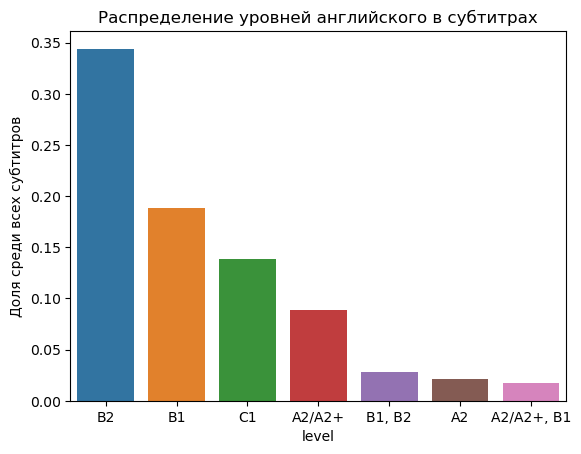

In [34]:
level_distribution = df.level.value_counts(dropna=False, normalize=True)
sns.barplot(x=level_distribution.index,
             y=level_distribution.values)\
                .set(title='Распределение уровней английского в субтитрах', \
                     ylabel='Доля среди всех субтитров');

Оставим 4 основных уровня знания языка:
* A2, A2+ - Beginner, Elementary 
* B1 - Intermediate 
* B2 - Upper-Intermediate 
* C1 - Advanced


In [42]:
df = df.replace({'level' :{'B1, B2': 'B1',
                      'A2': 'A2/A2+',
                      'A2/A2+, B1': 'A2/A2+'}})

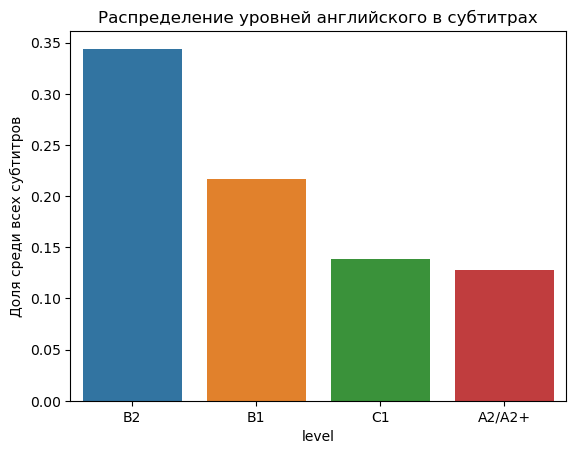

In [44]:
new_level_distribution = df.level.value_counts(dropna=False, normalize=True)
sns.barplot(x=new_level_distribution.index,
             y=new_level_distribution.values)\
                .set(title='Распределение уровней английского в субтитрах', \
                     ylabel='Доля среди всех субтитров');

Присутствует дисбаланс классов

### Обработка данных

#### Приведение к нижнему регистру, обработка спецсимволов и "стоп-слов"

In [53]:
# Пример "стоп-слов"
np.array(stopwords.words('english'))[:20]

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his'], dtype='<U10')

In [91]:
def preprocess_text(data, stopwords=stopwords.words('english')):
    #Приводим к нижему регистру
    text = data.lower()
    #Удаляем все символы между <>, '<some symbols>' -> ''
    text = re.sub('<[^>]+>', '', text)
    #Добавляем пробелы между знаками препинания
    text = re.sub(r"([.,!?])", r" \1 ", text)
    # удаляем пробелы в начале и в конце предложения
    text = text.strip()
    # Оставляем только латинские буквы
    text = re.sub(r'[^a-z]', ' ', text)
    # удаление стоп-слов
    text = [w for w in text.split() if w not in stopwords]
    # удаляем слова короче 3х символов
    text = [w for w in text if len(w) >= 3]
    return ' '.join(text)

In [93]:
df.subtitle = df.subtitle.apply(lambda text: preprocess_text(text))

#### Стемминг и лемматизация

In [99]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [104]:
flag = 0
if flag:
    df['lemma_clear_text'] = df.subtitle.apply(lambda row: lemmatize(row))
else:
    with open('df_lemma.pickle', 'rb') as file:
        df = pickle.load(file)

### Векторизация